# Learning diffusion with a neural partial differential equation

In [6]:
using LinearAlgebra

using DifferentialEquations
using Flux
using DiffEqFlux

using Plots
default(fmt = :png)

We want to solve the heat (or diffusion) equation

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}, \quad x \in \left[-\frac{1}{2}, \frac{1}{2}\right], \quad x\left(-\frac{1}{2}\right) = x\left(\frac{1}{2}\right)$$

Let's go with $N = 16$ grid points and $\kappa = 1$.

In [4]:
const N = 16
const L = 1
const Δx = L / N
const κ = 1

x = range(-L/2, L/2, length=N)

-0.5:0.06666666666666667:0.5

Discretizing the spatial derivative with a second-order centered finite-difference

$$\frac{\partial u_i}{\partial t} = \frac{\partial^2 u}{\partial x^2} \approx \kappa \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta x^2}$$

we get a system of $N$ coupled ODEs which can be described as

$$ \frac{\partial u}{\partial t} = Au $$

where $A$ is a matrix.

In [3]:
 d = -2 * ones(N) # Diagonal
sd = ones(N-1)    # Sub-diagonals
A = Array(Tridiagonal(sd, d, sd))

# Impose periodic boundary conditions
A[1, N] = 1
A[N, 1] = 1

# Dimensionalize A
A_diffusion = (κ/Δx^2) .* A

function diffusion(∂u∂t, u, p, t)
    ∂u∂t .= A_diffusion * u
    return 
end

diffusion (generic function with 1 method)

Let's generate an initial condition

$$ u_0(x) = e^{-100x^2} $$

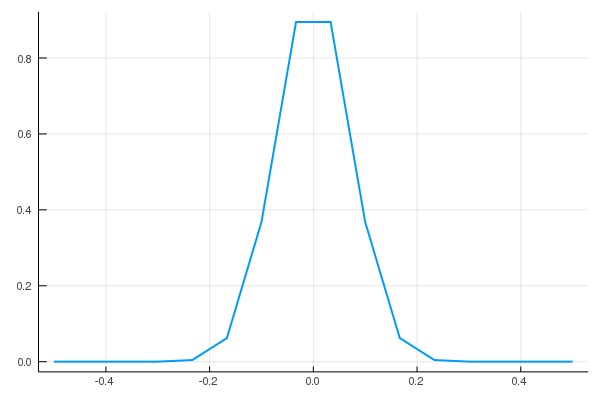

In [9]:
u₀ = @. exp(-100*x^2)

plot(x, u₀, linewidth=2, label="")

We'll pick 30 equally spaced times between $t = 0$ and $t = 0.1$ to save the state of the PDE.

In [10]:
tspan = (0.0, 0.1)
datasize = 30
t = range(tspan[1], tspan[2], length=datasize)

0.0:0.0034482758620689655:0.1

Set up and solve the PDE.

In [11]:
prob = ODEProblem(diffusion, u₀, tspan)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

16×30 Array{Float64,2}:
 1.38879e-11  0.000160344  0.00215047  …  0.158223  0.159223  0.160099
 6.99705e-9   0.00087666   0.00636828     0.159464  0.160304  0.161033
 1.44928e-6   0.00462848   0.0199546      0.161636  0.16221   0.16272 
 0.00012341   0.020396     0.0546109      0.164632  0.16482   0.164975
 0.00432024   0.0726686    0.126828       0.167703  0.167515  0.16736 
 0.0621765    0.201762     0.245097    …  0.170699  0.170125  0.169615
 0.367879     0.417262     0.386382       0.172871  0.172031  0.171302
 0.894839     0.611587     0.48795        0.174112  0.173112  0.172236
 0.894839     0.611587     0.48795        0.174112  0.173112  0.172236
 0.367879     0.417262     0.386382       0.172871  0.172031  0.171302
 0.0621765    0.201762     0.245097    …  0.170699  0.170125  0.169615
 0.00432024   0.0726686    0.126828       0.167703  0.167515  0.16736 
 0.00012341   0.020396     0.0546109      0.164632  0.16482   0.164975
 1.44928e-6   0.00462848   0.0199546      0.161636  0

Let's plot the solution

In [13]:
@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 1), label="", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

Now let's create a two-layer neural network to see if we can learn diffusion

In [16]:
dudt_NN = Chain(Dense(N, 100, tanh),
             Dense(100, N))

Chain(Dense(16, 100, tanh), Dense(100, 16))

Set up a neural PDE that solves the system of ODEs described by

$$ \frac{\partial u}{\partial t} = \text{NN}(u) $$

In [18]:
ps = Flux.params(dudt_NN)
neural_pde_prediction = u₀ -> neural_ode(dudt_NN, u₀, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)

#5 (generic function with 1 method)

Define the loss/objective function to be

$$ \left| u(x, t) - u_{NN}(x, t) \right|^2 \approx \sum_{n=1}^{N_t} \sum_{i=1}^{N_x} \left| u_i^n - (u_{NN})_i^n \right|^2 $$

In [19]:
loss_function() = sum(abs2, ode_data .- neural_pde_prediction(u₀))

loss_function (generic function with 1 method)

Use the Adam optimization algorithm (adaptive moment estimation?). Seems to be recommended as a good default.

In [20]:
data = Iterators.repeated((), 1000)  # Not sure what this does...
opt = ADAM(0.1)

ADAM(0.1, (0.9, 0.999), IdDict{Any,Any}())

Define a callback function to observe training in progress and stop once loss is acceptable.

In [21]:
cb = function ()
  loss = loss_function()
  println("loss = $loss")
  loss < 0.1 && Flux.stop()
end

cb()

loss = 34.273596938328204 (tracked)


false

Training!

In [24]:
Flux.train!(loss_function, ps, data, opt, cb = cb)

loss = 18.11951469735577 (tracked)
loss = 28.107671508293638 (tracked)
loss = 4.328431063850267 (tracked)
loss = 8.28430574317708 (tracked)
loss = 6.924196766144397 (tracked)
loss = 3.019241189654479 (tracked)
loss = 4.008298484794201 (tracked)
loss = 5.840403337656129 (tracked)
loss = 2.338185429252329 (tracked)
loss = 4.0677154012769705 (tracked)
loss = 4.62279976064551 (tracked)
loss = 2.41761599420033 (tracked)
loss = 1.780022118343593 (tracked)
loss = 3.6248358952887774 (tracked)
loss = 1.6584211104351354 (tracked)
loss = 1.2845198290747533 (tracked)
loss = 1.9849795902505512 (tracked)
loss = 1.8358079209649756 (tracked)
loss = 1.2754690851043986 (tracked)
loss = 1.2967433712916776 (tracked)
loss = 1.387559426876048 (tracked)
loss = 0.9566162729755848 (tracked)
loss = 0.9292443423576888 (tracked)
loss = 1.2079394158540124 (tracked)
loss = 1.1041354502751142 (tracked)
loss = 0.724862934435269 (tracked)
loss = 0.5951120771249366 (tracked)
loss = 0.7425156464279931 (tracked)
loss = 0

Let's see how well it fit the training data.

In [25]:
nn_pred = Flux.data(n_ode(u₀))

@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 1), label="data", show=false)
    plot!(x, nn_pred[:, n], linewidth=2, ylim=(0, 1), label="Neural PDE", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

Let's see how well it fits

$$ u_0(x) = 1 - cos(2\pi x) $$

In [31]:
u₀_cos = @. 1 - cos(2π * x)

prob = ODEProblem(diffusion, u₀_cos, tspan)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

nn_pred = Flux.data(n_ode(u₀_cos))
@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 2), label="data", show=false)
    plot!(x, nn_pred[:, n], linewidth=2, ylim=(0, 2), label="Neural ODE", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

In [ ]:
plot(1:10)